In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import random
policy = tf.keras.mixed_precision.Policy("float32")
tf.keras.mixed_precision.set_global_policy(policy)
scaler = MinMaxScaler()

import warnings
warnings.filterwarnings('ignore')


./BraTS2021_Training_Data/BraTS2021_01388


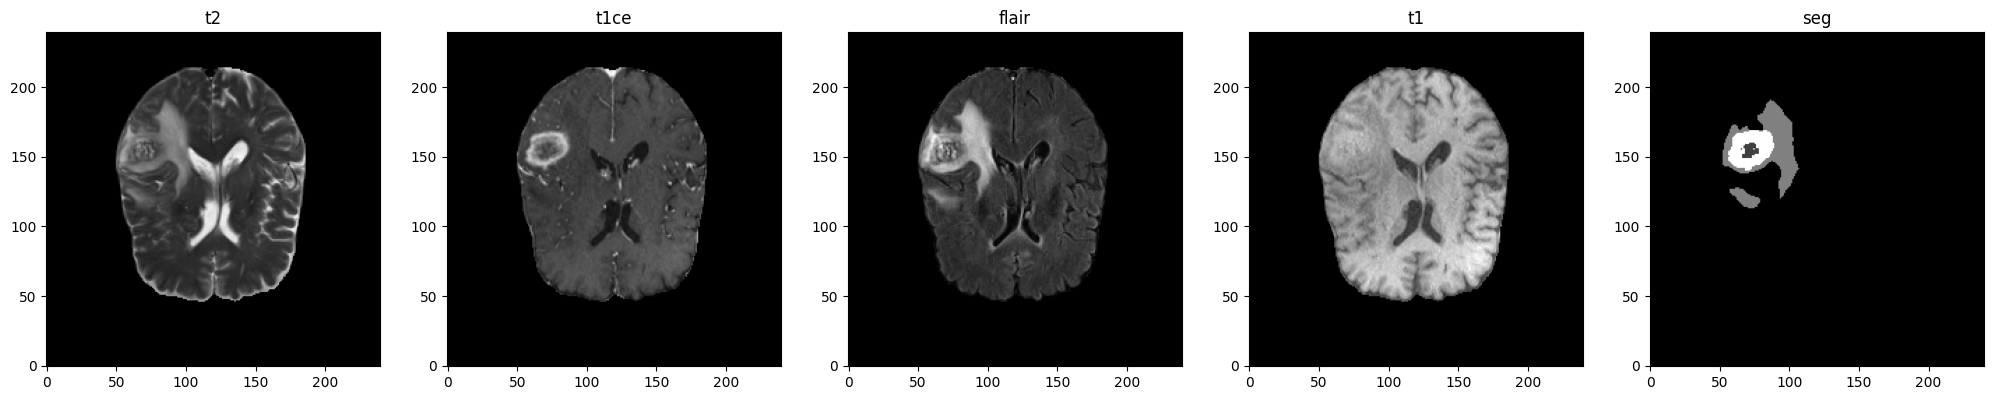

In [36]:
file_path = "./BraTS2021_Training_Data"

fig,axes = plt.subplots(1,5, figsize=(25,10))
a = np.random.randint(1,100)
#for i in (os.listdir(file_path)):
i = os.path.join(file_path, (os.listdir(file_path)[10]))
subpath = i
print(subpath)
for x, j in enumerate(os.listdir(subpath)):
    scans = (j.split("_"))[2][:-7] # to get label from filename
    img = nib.load(os.path.join(subpath,j))
    data = img.get_fdata()
     #cropping into 128x128x128 shape
    # Choose a slice in the middle of the volume
    slice_index = data.shape[2] // 2
    axes[x].imshow(data[:, :, slice_index].T, cmap='gray', origin='lower')
    axes[x].set_title(scans)

    # Show the plot
plt.show()

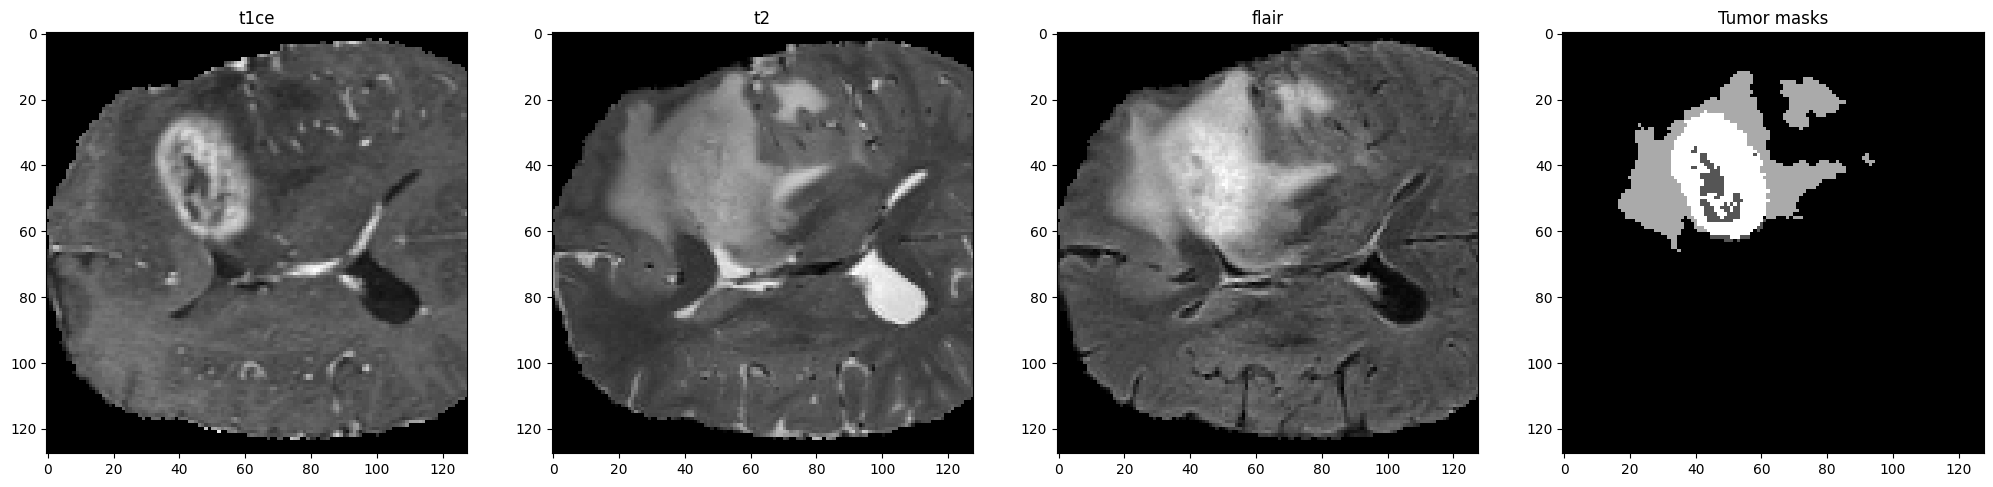

In [25]:
file_path = "./3Dimages"

fig, ax = plt.subplots(1,4, figsize=(25,10))
patient = os.listdir(file_path)[9]

subpath = os.path.join(file_path, patient)
mask_path = "./3Dmasks"
maskpath = os.path.join(mask_path, patient)
image = np.load(subpath)
mask = np.load(maskpath)
mask = np.argmax(mask, axis=-1)

names = ['t1ce','t2','flair']

for i in range(0,3):
    ax[i].imshow(image[:,:,64,i],cmap='gray')
    ax[i].set_title(names[i])
ax[3].imshow(mask[:,:,64], cmap='gray')
ax[3].set_title('Tumor masks')
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


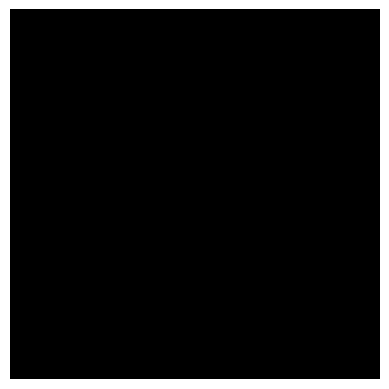

In [37]:
import imageio
import matplotlib.animation as animate

img_path = "./BraTS2021_Training_Data/BraTS2021_01388/BraTS2021_01388_t1ce.nii.gz"
img = nib.load(img_path).get_fdata()

def create_gif(input_image, title='.gif', filename='test.gif'):
    # see example from matplotlib documentation
    images = []
    fig = plt.figure()
    for i in range(input_image.shape[2]):
        im = plt.imshow(input_image[:,:,i],cmap='gray',animated=True)
        images.append([im])
    
    ani = animate.ArtistAnimation(fig, images, interval=25,\
        blit=True, repeat_delay=500)
    plt.title(title, fontsize=20)
    plt.axis('off')
    ani.save(filename)
    plt.show()

create_gif(img, title=None, filename='brain.gif')

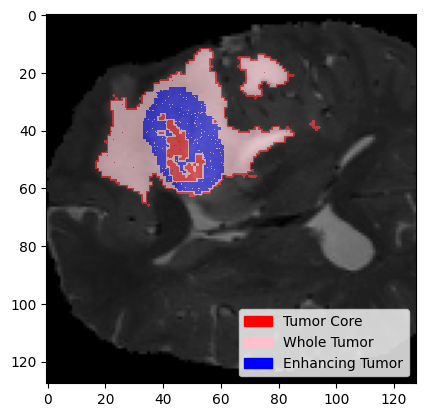

In [ ]:
import matplotlib.patches as mpatches
from matplotlib import colors
slice_number = 64
cmap = colors.ListedColormap(['black','red','pink','blue'])
bounds = [0,1,2,3,4]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.imshow(image[:,:,slice_number,1],cmap='gray')
plt.imshow(mask[:,:,slice_number], cmap=cmap, norm=norm, alpha=0.5)
legend_patches = [
    mpatches.Patch(color='red', label='Tumor Core'),
    mpatches.Patch(color='pink', label='Whole Tumor'),
    mpatches.Patch(color='blue', label='Enhancing Tumor')
]
plt.legend(handles=legend_patches, loc="lower right")
plt.show()

In [3]:
def generator(img_dir, img_list, mask_dir, mask_list, batch_size=2):
    L = len(img_list)
    temp = list(zip(img_list, mask_list))
    random.shuffle(temp) #shuffle after each epoch
    imgs, msks = zip(*temp)
    img_list, mask_list = list(imgs), list(msks)

    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield(X,Y)

            batch_start += batch_size
            batch_end += batch_size

def load_img(dir, img):
    images = []
    for i, image_name in enumerate(img):
        if (image_name.split('.')[1] == 'npy'):
            image = np.load(dir+image_name)

            images.append(image)
    images = np.array(images)
    return images

def load_and_save_files(base_path, patient_list):
    scaler = MinMaxScaler()
    for patient in patient_list:
        patient_path = os.path.join(base_path, patient)
        t1ce_path = os.path.join(patient_path,f"{patient}_t1ce.nii.gz")
        t2_path = os.path.join(patient_path,f"{patient}_t2.nii.gz")
        flair_path = os.path.join(patient_path,f"{patient}_flair.nii.gz")
        seg_path = os.path.join(patient_path,f"{patient}_seg.nii.gz")

        t1ce = np.array(nib.load(t1ce_path).get_fdata()).astype(np.float32)
        t1ce = scaler.fit_transform(t1ce.reshape(-1, t1ce.shape[-1])).reshape(t1ce.shape)
        t1ce = t1ce[56:184, 56:184,14:142]

        t2 = np.array(nib.load(t2_path).get_fdata()).astype(np.float32)
        t2 = scaler.fit_transform(t2.reshape(-1, t2.shape[-1])).reshape(t2.shape)
        t2 = t2[56:184, 56:184,14:142]

        flair = np.array(nib.load(flair_path).get_fdata()).astype(np.float32)
        flair = scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)
        flair = flair[56:184, 56:184,14:142]

        seg = np.array(nib.load(seg_path).get_fdata())
        seg[seg == 4] = 3
        seg = seg.astype(np.uint8)
        seg = seg[56:184, 56:184,14:142]
        seg = to_categorical(seg, num_classes=4)

        combined = np.stack([t1ce, t2, flair], axis=-1)

        with open (f'./3Dimages/{patient}.npy', 'wb') as f:
            np.save(f, combined)
        with open (f'./3Dmasks/{patient}.npy', 'wb') as m: 
            np.save(m, seg)


In [4]:
from sklearn.model_selection import train_test_split

img_dir = "./3Dimages/"
mask_dir = "./3Dmasks/"
imgs = os.listdir(img_dir)
masks = os.listdir(mask_dir)

x_train, x_val, y_train, y_val = train_test_split(imgs, masks, test_size=0.2, random_state=42)

In [5]:
batch_size = 2

train_gen = generator(img_dir, x_train, mask_dir, y_train, batch_size=batch_size)
val_gen = generator(img_dir, x_val, mask_dir, y_val, batch_size=batch_size)

In [64]:
def encoder(input_tensor, n_filters, kernel_size=(3,3,3)):
  x = layers.Conv3D(n_filters, kernel_size, padding='same')(input_tensor)
  x = layers.GroupNormalization(groups=2)(x)
  x = layers.ReLU()(x)

  x = layers.Conv3D(n_filters, kernel_size, padding='same')(input_tensor)
  x = layers.GroupNormalization(groups=2)(x)

  residual = layers.Conv3D(n_filters, kernel_size=(1,1,1), padding='same')(input_tensor)
  x = layers.add([x, residual])

  x = layers.ReLU()(x)

  return x

def AttentionGate(input_tensor, n_filters, gating_signal):
  ds_x = layers.Conv3D(n_filters, (2,2,2), strides=(2,2,2), padding='same')(input_tensor) #matching dimesion to gating signal
  ds_gate = layers.Conv3D(n_filters,(1,1,1), padding='same')(gating_signal) #not necessary, just to match dimension to input tensor

  #addition and relu
  add_xgate = layers.add([ds_x, ds_gate])
  relu_xgate = layers.ReLU()(add_xgate)

  #conv and sigmoid operations to capture features
  psi = layers.Conv3D(1, (1,1,1), padding='same')(relu_xgate)
  sig = layers.Activation('sigmoid')(psi)

  #upsample to gating signal's original dimensions
  resampler = layers.UpSampling3D(size=(2,2,2))(sig)

  #attention output
  output = layers.multiply([input_tensor, resampler])

  return output

In [14]:
def build_model(input_shape=(128,128,128,3), n_classes=4):
  inputs = layers.Input(input_shape)

  #4 layers of encoder
  e1 = encoder(inputs, 16, (3,3,3))
  p1 = layers.MaxPooling3D(pool_size=(2,2,2))(e1)

  e2 = encoder(p1, 32, (3,3,3))
  p2 = layers.MaxPooling3D(pool_size=(2,2,2))(e2)
  p2 = layers.Dropout(0.2)

  e3 = encoder(p2, 64, (3,3,3))
  p3 = layers.MaxPooling3D(pool_size=(2,2,2))(e3)

  #bottleneck
  e4 = encoder(p3, 128, (3,3,3))
  p4 = layers.MaxPooling3D(pool_size=(2,2,2))(e4)
  p4 = layers.Dropout(0.5)

  e5 = encoder(p4, 256, (3,3,3))

  #attention gates and upsampling
  a1 = AttentionGate(e4, 128, e5)
  u1 = layers.Conv3DTranspose(128, (2,2,2), strides=(2,2,2), padding='same')(e5)
  u1 = layers.concatenate([a1,u1])
  e7 = encoder(u1, 128)

  a2 = AttentionGate(e3, 64, e4)
  u2 = layers.Conv3DTranspose(64, (2,2,2), strides=(2,2,2), padding='same')(e4)
  u2 = layers.concatenate([a2,u2])
  e7 = encoder(u2, 64)
  e7 = layers.Dropout(0.25)

  a3 = AttentionGate(e2, 32, e7)
  u3 = layers.Conv3DTranspose(32, (2,2,2), strides=(2,2,2), padding='same')(e7)
  u3 = layers.concatenate([a3,u3])
  e8 = encoder(u3,32)

  a4 = AttentionGate(e1, 16, e8)
  u4 = layers.Conv3DTranspose(16, (2,2,2), strides=(2,2,2), padding='same')(e8)
  u4 = layers.concatenate([a4, u4])
  e9 = encoder(u4, 16)


  #output
  outputs = layers.Conv3D(n_classes, (1,1,1), activation='softmax')(e9)

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [38]:
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

@tf.keras.utils.register_keras_serializable()
def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

@tf.keras.utils.register_keras_serializable()
def per_class_dice(class_index):
    def dice(y_true, y_pred):
        # Convert the true labels to a one-hot encoding (if needed)
        y_true_class = tf.cast(tf.equal(tf.argmax(y_true, axis=-1), class_index), tf.float32)
        
        # Convert the predicted labels to a one-hot encoding
        y_pred_class = tf.cast(tf.equal(tf.argmax(y_pred, axis=-1), class_index), tf.float32)
        
        # Flatten the arrays
        y_true_f = tf.keras.backend.flatten(y_true_class)
        y_pred_f = tf.keras.backend.flatten(y_pred_class)
        
        # Calculate intersection and Dice coefficient
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        return (2. * intersection + 1e-6) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-6)
    
    return dice


In [ ]:
"""#Attention Residual 3D U-Net
model = build_model((128,128,128,3),4)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=[iou, per_class_dice(1), per_class_dice(2), per_class_dice(3)])
callbacks = ModelCheckpoint('./saved/3dbrain.keras', verbose=1, save_best_only=True,monitor='loss')"""

In [39]:
from keras.saving import load_model
model = load_model("./saved/3dbrain.keras")
callbacks = ModelCheckpoint('./saved/retrained_3dbrain.keras', verbose=1, save_best_only=True,monitor='loss')

In [ ]:
#uncomment to train/retrain
"""steps_per_epoch = len(x_train)//batch_size
val_steps_per_epoch = len(x_val)//batch_size

history = model.fit(train_gen, epochs=30, validation_data=val_gen, 
                    verbose=1, steps_per_epoch=steps_per_epoch, 
                    validation_steps=val_steps_per_epoch, callbacks=callbacks)"""

In [40]:
def load_files_test(file_dir):
    patient_list = os.listdir(file_dir)
    imgs, masks = [], []
    for patient in patient_list:
        patient_path = os.path.join(file_dir, patient)
        t1ce_path = os.path.join(patient_path,f"{patient}_t1ce.nii.gz")
        t2_path = os.path.join(patient_path,f"{patient}_t2.nii.gz")
        flair_path = os.path.join(patient_path,f"{patient}_flair.nii.gz")
        seg_path = os.path.join(patient_path,f"{patient}_seg.nii.gz")

        t1ce = np.array(nib.load(t1ce_path).get_fdata()).astype(np.float32)
        t1ce = scaler.fit_transform(t1ce.reshape(-1, t1ce.shape[-1])).reshape(t1ce.shape)
        t1ce = t1ce[56:184, 56:184,14:142]

        t2 = np.array(nib.load(t2_path).get_fdata()).astype(np.float32)
        t2 = scaler.fit_transform(t2.reshape(-1, t2.shape[-1])).reshape(t2.shape)
        t2 = t2[56:184, 56:184,14:142]

        flair = np.array(nib.load(flair_path).get_fdata()).astype(np.float32)
        flair = scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)
        flair = flair[56:184, 56:184,14:142]

        seg = np.array(nib.load(seg_path).get_fdata())  
        seg[seg == 4] = 3
        seg = seg.astype(np.uint8)
        seg = seg[56:184, 56:184,14:142]
        seg = to_categorical(seg, num_classes=4)

        combined = np.stack([t1ce, t2, flair], axis=-1)

        imgs.append(combined)
        masks.append(seg)
    
    return imgs, masks

        

test_path = "./validation"
test_image, test_masks = load_files_test(test_path)

In [41]:
from keras.saving import load_model
model = load_model('./saved/3dbrain.keras')
test_img = test_image[0]

test_mask = test_masks[0]

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)

print(test_mask.shape, test_prediction.shape)

y_pred_binary = np.argmax(test_prediction, axis=-1) 
y_pred_binary = y_pred_binary.squeeze(0)
test_mask = np.argmax(test_mask, axis=-1)
print(test_mask.shape, y_pred_binary.shape)

final_mask = np.zeros_like(y_pred_binary)
final_mask[y_pred_binary == 1] = 1  #tumor core
final_mask[y_pred_binary == 2] = 2  #edema/whole tumor
final_mask[y_pred_binary == 3] = 3  #enhancing tumor

I0000 00:00:1729504460.414006 5126624 service.cc:146] XLA service 0x32bb50920 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729504460.414249 5126624 service.cc:154]   StreamExecutor device (0): Host, Default Version
2024-10-21 20:54:20.479245: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1729504461.069415 5126624 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
(128, 128, 128, 4) (1, 128, 128, 128, 4)
(128, 128, 128) (128, 128, 128)


In [42]:
final_mask.shape

(128, 128, 128)

In [49]:
test_img.shape

(128, 128, 128, 3)

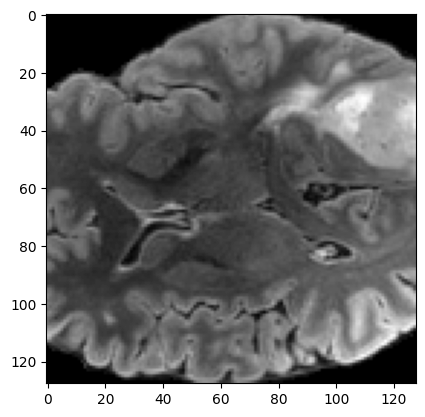

In [53]:
plt.imshow(test_img[:,:,64,2], cmap='gray')

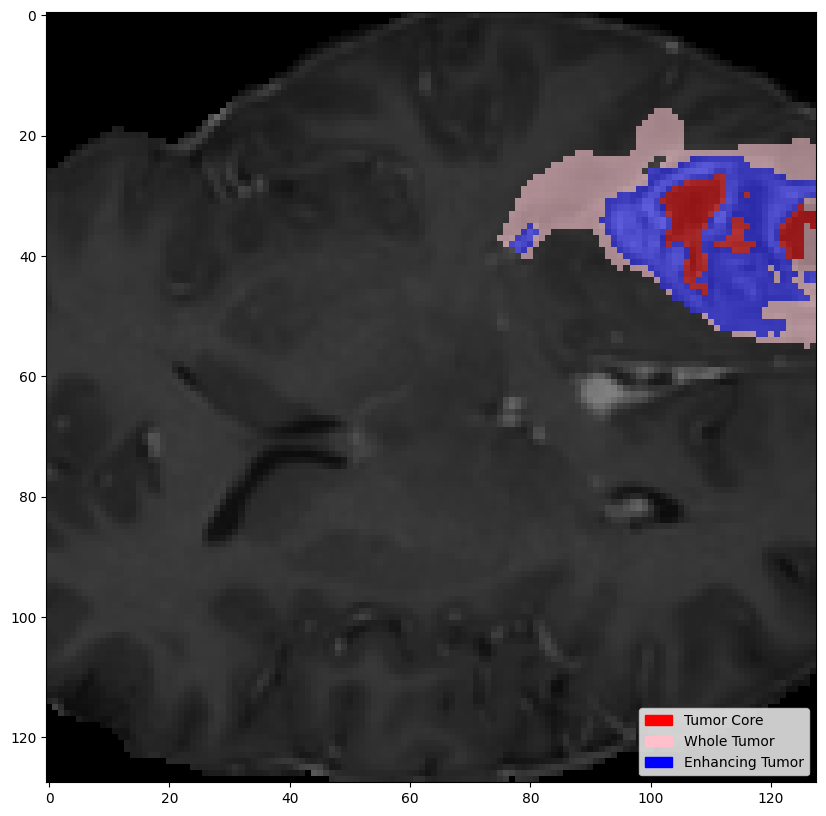

In [50]:
cmap = colors.ListedColormap(['black','red','pink','blue'])
fig, ax = plt.subplots(figsize=(10,10))
slice_number=64
bounds = [0,1,2,3,4]
norm = colors.BoundaryNorm(bounds, cmap.N)
ax.imshow(test_img[:,:,slice_number,0],cmap='gray')
ax.imshow(final_mask[:,:,slice_number], cmap=cmap, norm=norm, alpha=0.5)
legend_patches = [
    mpatches.Patch(color='red', label='Tumor Core'),
    mpatches.Patch(color='pink', label='Whole Tumor'),
    mpatches.Patch(color='blue', label='Enhancing Tumor')
]
plt.legend(handles=legend_patches, loc="lower right")

Text(0.5, 1.0, 'Brain MRI Image')

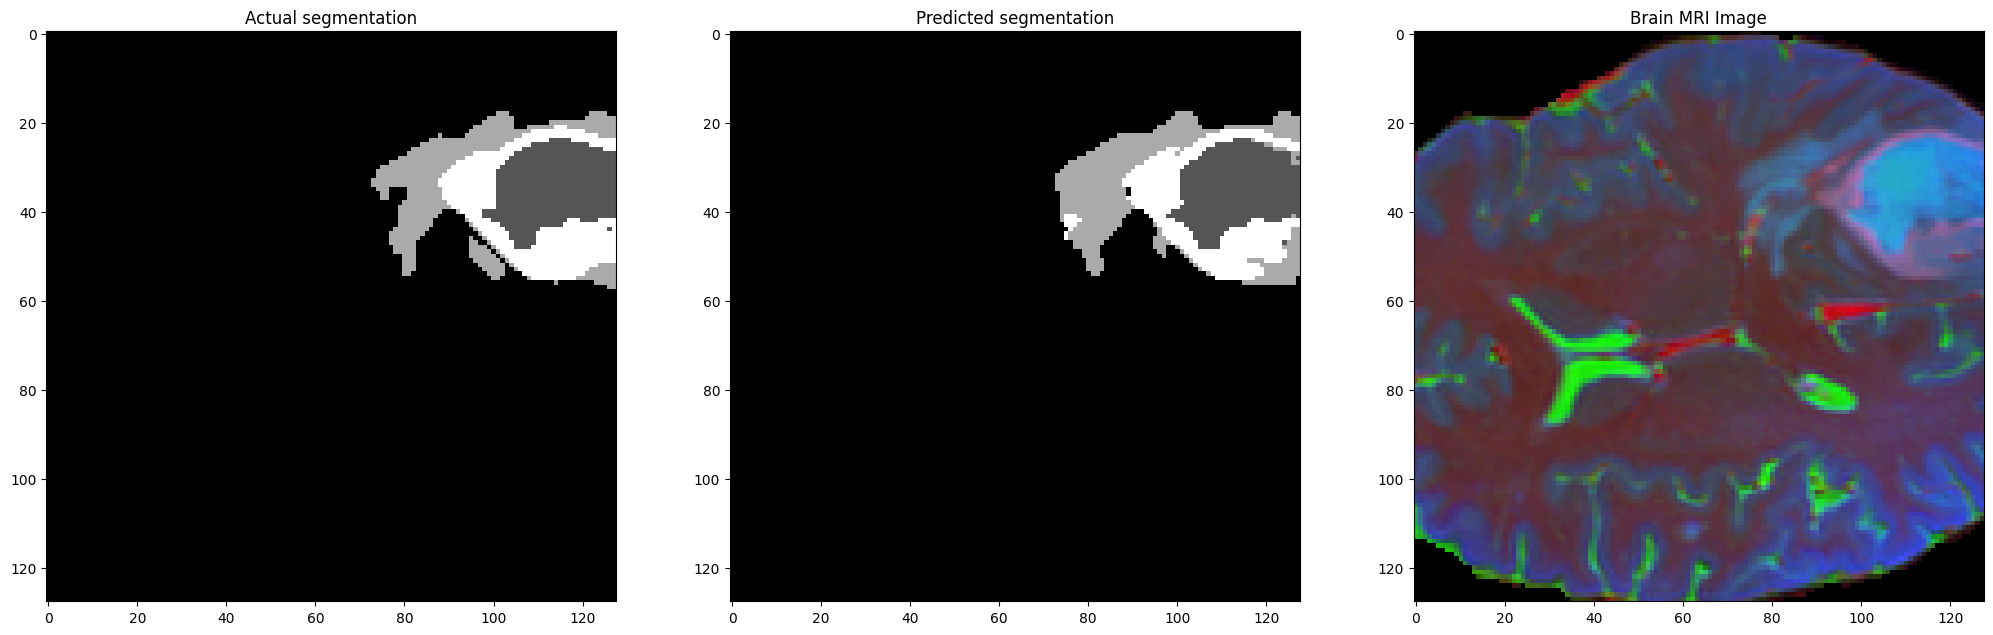

In [108]:
fig, ax = plt.subplots(1,3, figsize=(25,10))
ax[0].imshow(test_mask[:,:,70], cmap='gray')
ax[0].set_title('Actual segmentation')
ax[1].imshow(final_mask[:,:,70], cmap='gray')
ax[1].set_title('Predicted segmentation')
ax[2].imshow(test_img[:,:,70], cmap='gray')
ax[2].set_title('Brain MRI Image')

In [112]:
def dice_coefficient(pred, gt, class_idx):
    pred_class = (pred == class_idx)  # Binary mask for class class_idx
    gt_class = (gt == class_idx)      # Binary mask for class class_idx
    
    intersection = np.sum(pred_class * gt_class)
    union = np.sum(pred_class) + np.sum(gt_class)
    
    if union == 0:  # Avoid division by zero
        return 1 if np.sum(gt_class) == 0 else 0
    
    dice = 2 * intersection / union
    return dice

def iou_score(pred, gt, class_idx):
    pred_class = (pred == class_idx)
    gt_class = (gt == class_idx)
    
    intersection = np.sum(pred_class * gt_class)
    union = np.sum((pred_class + gt_class) > 0)
    
    if union == 0:
        return 1 if np.sum(gt_class) == 0 else 0
    
    iou = intersection / union
    return iou

from scipy.spatial.distance import directed_hausdorff

def hausdorff_distance(pred, gt, class_idx):
    pred_class = (pred == class_idx)
    gt_class = (gt == class_idx)
    
    pred_points = np.argwhere(pred_class)
    gt_points = np.argwhere(gt_class)
    
    return max(directed_hausdorff(pred_points, gt_points)[0], 
               directed_hausdorff(gt_points, pred_points)[0])


classes = [0, 1, 2, 3]
class_names = ['Background', 'Tumor Core', 'Whole Tumor', 'Enhancing Tumor']
dice_scores = [dice_coefficient(final_mask, test_mask, c) for c in classes]
iou_scores = [iou_score(final_mask, test_mask, c) for c in classes]
hausdorff_distances = [hausdorff_distance(final_mask, test_mask, c) for c in classes]

results = pd.DataFrame({
    'Class': class_names,
    'Dice Scores': dice_scores,
    'IOU Scores': iou_scores,
    'Hausdorff Distance': hausdorff_distances    
})

results

,Class,Dice Scores,IOU Scores,Hausdorff Distance
0,Background,0.998109,0.996225,7.141428
1,Tumor Core,0.933744,0.875722,6.403124
2,Whole Tumor,0.869381,0.768942,14.212670
3,Enhancing Tumor,0.879072,0.784236,16.062378


# Classes : 
- 0 Background
- 1 necrotic/ non enhancing tumor core (gray)
- 2 Edema : region surrounding tumor with fluid accumulation (light gray)
- 3 Enhancing Tumor : Active part of tumor (white)